In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"

In [ ]:
%cd /content/drive/My Drive/Kaggle

/content/drive/My Drive/Kaggle


In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import sklearn
import itertools
import scipy
import skimage
from skimage.transform import resize
import csv
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import keras
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
from keras.models import Sequential, model_from_json
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,Callback, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
import tensorflow as tf
import pickle as pkl
from keras.layers import Dense
import pickle
from tqdm import tqdm
import random
random.seed(123)

In [ ]:
with open("/content/drive/My Drive/Kaggle/train.pkl", "rb") as f1:
    x_train, y_train = pkl.load(f1)

In [ ]:

with open("/content/drive/My Drive/Kaggle/test.pkl", "rb") as f2:
    x_test, y_test = pkl.load(f2)


In [ ]:
with open("/content/drive/My Drive/Kaggle/val.pkl", "rb") as f3:
    x_val, y_val = pkl.load(f3)

In [ ]:
batch_size=64
train_datagen = ImageDataGenerator(
        rescale=1.0/255,  
        height_shift_range= 0.05, 
        width_shift_range=0.1,    
        zoom_range=0.1,
        fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [ ]:
train_batch = train_datagen.flow(x_train,y_train,batch_size=batch_size,shuffle=True)
test_batch = test_datagen.flow(x_test,y_test,batch_size=batch_size,shuffle=False)
val_batch = test_datagen.flow(x_val,y_val,batch_size=batch_size,shuffle=True)

In [ ]:
file_path="/content/drive/My Drive/Colab Notebooks/Xception2.hdf5"
"""llr=ReduceLROnPlateau(monitor='val_loss',factor=0.1,verbose=1, mode='auto',patience=5,min_delta=0.0001,min_lr=0.00001, cooldown=0)"""
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
early = EarlyStopping(monitor="val_loss", mode='auto', patience=5,restore_best_weights=True)
callbacks_list = [checkpoint,early]

In [ ]:
base_model=tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3),
)
base_model.trainable = False

In [ ]:
inputs = keras.Input(shape=(128, 128, 3))
x = base_model(inputs, training=False)
x = keras.layers.Dropout(0.7)(x)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.7)(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(4,activation='softmax')(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 20,869,676
Trainable params: 8,196
Non-trainable params: 20,861,480
______________________________________

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(0.001),metrics=['accuracy'])

In [ ]:
history=model.fit_generator(train_batch, validation_data=val_batch, epochs=100, validation_steps= x_val.shape[0] // batch_size, 
                       steps_per_epoch= x_train.shape[0] // batch_size, callbacks=[callbacks_list], verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
430/430 [==============================] - ETA: 0s - loss: 1.1570 - accuracy: 0.5118
Epoch 00001: val_loss improved from inf to 0.84387, saving model to /content/drive/My Drive/Colab Notebooks/Xception2.hdf5
430/430 [==============================] - 96s 223ms/step - loss: 1.1570 - accuracy: 0.5118 - val_loss: 0.8439 - val_accuracy: 0.6701
Epoch 2/100
430/430 [==============================] - ETA: 0s - loss: 0.9999 - accuracy: 0.5913
Epoch 00002: val_loss improved from 0.84387 to 0.80432, saving model to /content/drive/My Drive/Colab Notebooks/Xception2.hdf5
430/430 [==============================] - 95s 220ms/step - loss: 0.9999 - accuracy: 0.5913 - val_loss: 0.8043 - val_accuracy: 0.6875
Epoch 3/100
430/430 [==============================] - ETA: 0s - loss: 0.9877 - accuracy: 0.5954
Epoch 00003: val_loss did not improve from 0.80432
430/430 [==============================] - 93s 216ms/step - loss

In [ ]:
def plot_learning_curve(history):
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('/content/drive/My Drive/Colab Notebooks/x_accuracy_curve2-2-before.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('/content/drive/My Drive/Colab Notebooks/x_loss_curv2e-2-before.png')

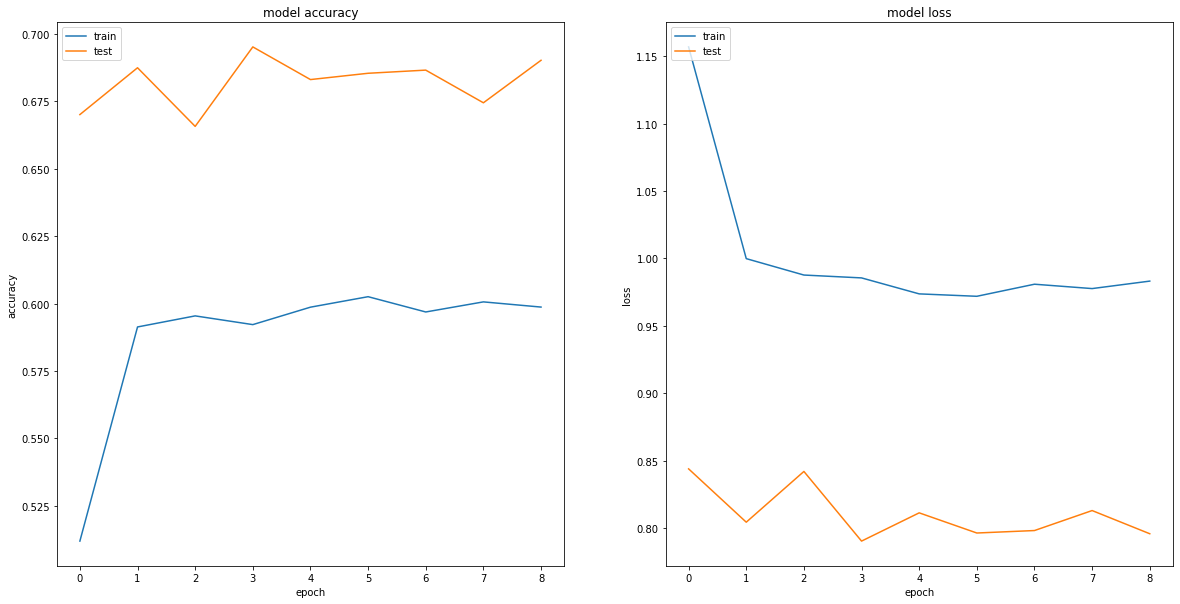

In [ ]:
plot_learning_curve(history)
plt.show()

In [ ]:
model.load_weights("/content/drive/My Drive/Colab Notebooks/Xception2.hdf5")
score=model.evaluate(test_batch)
print(score[1])

16/16 [==============================] - 1s 53ms/step - loss: 0.4806 - accuracy: 0.8709
0.8708677887916565


In [ ]:
y_pred = model.predict_generator(test_batch)
Y_pred = np.argmax(y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)

Instructions for updating:
Please use Model.predict, which supports generators.


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_true,Y_pred,target_names=['CNV','DME','DRUSEN','NORMAL']))

              precision    recall  f1-score   support

         CNV       0.84      0.88      0.86       242
         DME       0.86      0.82      0.84       242
      DRUSEN       0.88      0.82      0.85       242
      NORMAL       0.90      0.96      0.93       242

    accuracy                           0.87       968
   macro avg       0.87      0.87      0.87       968
weighted avg       0.87      0.87      0.87       968



In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('/content/drive/My Drive/Colab Notebooks/x_confuscion-2-before.png')

--------------------
| Confusion Matrix |
--------------------

 [[214  14  12   2]
 [ 16 199  11  16]
 [ 24  13 198   7]
 [  0   5   5 232]]


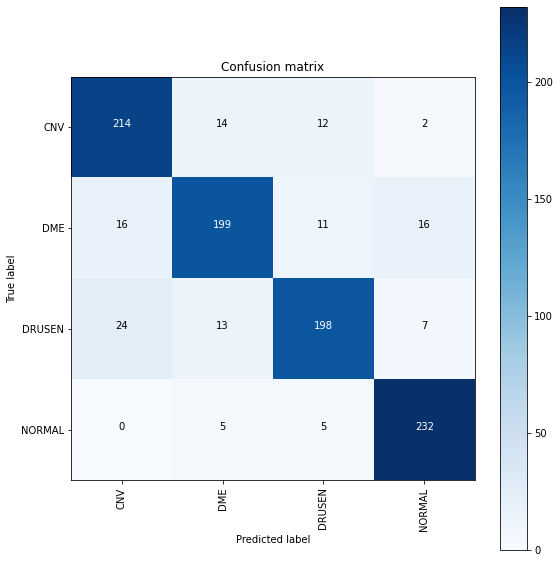

In [ ]:
# confusion matrix
cm = confusion_matrix(Y_true, Y_pred)
 
print('--------------------')
print('| Confusion Matrix |')
print('--------------------')
print('\n {}'.format(cm))
        
# plot confusin matrix
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(cm, classes=['CNV','DME','DRUSEN','NORMAL'], normalize=False, 
                      title='Confusion matrix', cmap = plt.cm.Blues)
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-5),metrics=['accuracy'])

In [ ]:
test_batch.reset()
train_batch.reset()
val_batch.reset()

In [ ]:
llr1=ReduceLROnPlateau(monitor='val_loss',factor=0.1,verbose=1, mode='auto',patience=5,min_delta=0.0001,min_lr=1e-6, cooldown=0)
checkpoint1 = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
early1 = EarlyStopping(monitor="val_loss", mode='auto', patience=8,restore_best_weights=True)
callbacks_list1 = [llr1,checkpoint1,early1]

In [ ]:
history=model.fit_generator(train_batch, validation_data=val_batch, epochs=100, validation_steps= x_val.shape[0] // batch_size, 
                       steps_per_epoch= x_train.shape[0] // batch_size, callbacks=[callbacks_list1], verbose=1)

Epoch 1/100
430/430 [==============================] - ETA: 0s - loss: 0.6342 - accuracy: 0.7549
Epoch 00001: val_loss improved from inf to 0.45024, saving model to /content/drive/My Drive/Colab Notebooks/Xception2.hdf5
430/430 [==============================] - 115s 268ms/step - loss: 0.6342 - accuracy: 0.7549 - val_loss: 0.4502 - val_accuracy: 0.8375
Epoch 2/100
430/430 [==============================] - ETA: 0s - loss: 0.4076 - accuracy: 0.8531
Epoch 00002: val_loss improved from 0.45024 to 0.35512, saving model to /content/drive/My Drive/Colab Notebooks/Xception2.hdf5
430/430 [==============================] - 116s 269ms/step - loss: 0.4076 - accuracy: 0.8531 - val_loss: 0.3551 - val_accuracy: 0.8705
Epoch 3/100
430/430 [==============================] - ETA: 0s - loss: 0.3319 - accuracy: 0.8819
Epoch 00003: val_loss improved from 0.35512 to 0.32419, saving model to /content/drive/My Drive/Colab Notebooks/Xception2.hdf5
430/430 [==============================] - 116s 269ms/step - l

In [ ]:
def plot_learning_curve1(history):
    plt.figure(figsize=(18,10))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('/content/drive/My Drive/Colab Notebooks/x_accurcacy_curve-2-after.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('/content/drive/My Drive/Colab Notebooks/x_locss_curve-2-after.png')

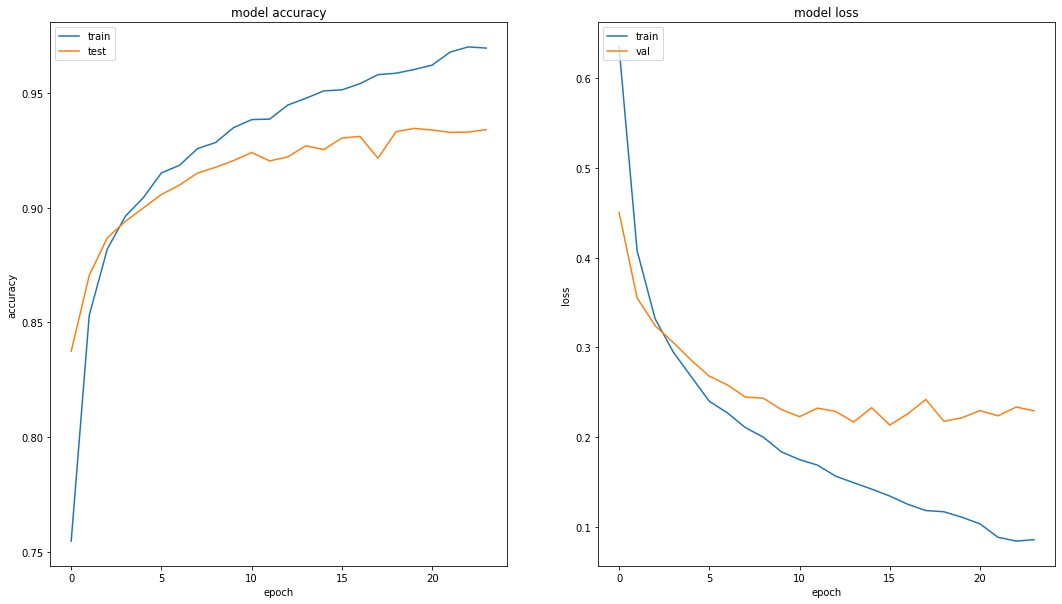

In [ ]:
plot_learning_curve1(history)
plt.show()

In [ ]:
model.load_weights("/content/drive/My Drive/Colab Notebooks/Xception2.hdf5")
score=model.evaluate(test_batch)
print(score[1])

16/16 [==============================] - 1s 47ms/step - loss: 0.0236 - accuracy: 0.9959
0.9958677887916565


In [ ]:
y_pred = model.predict_generator(test_batch)
Y_pred = np.argmax(y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)

In [ ]:
y_pred[0]

array([9.9999297e-01, 3.0199485e-07, 6.6124207e-06, 7.8032949e-09],
      dtype=float32)

In [ ]:
Y_pred[0]

0

In [ ]:
y_test[0]

array([1., 0., 0., 0.], dtype=float32)

In [ ]:
Y_true[0]

0

In [ ]:
print(Y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 

In [ ]:
print(Y_true)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_true,Y_pred,target_names=['CNV','DME','DRUSEN','NORMAL']))

              precision    recall  f1-score   support

         CNV       0.99      1.00      1.00       242
         DME       1.00      0.99      0.99       242
      DRUSEN       1.00      1.00      1.00       242
      NORMAL       0.99      1.00      1.00       242

    accuracy                           1.00       968
   macro avg       1.00      1.00      1.00       968
weighted avg       1.00      1.00      1.00       968



In [ ]:
def plot_confusion_matrix1(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('/content/drive/My Drive/Colab Notebooks/x_concfusion-2-after.png')

--------------------
| Confusion Matrix |
--------------------

 [[242   0   0   0]
 [  1 239   0   2]
 [  1   0 241   0]
 [  0   0   0 242]]


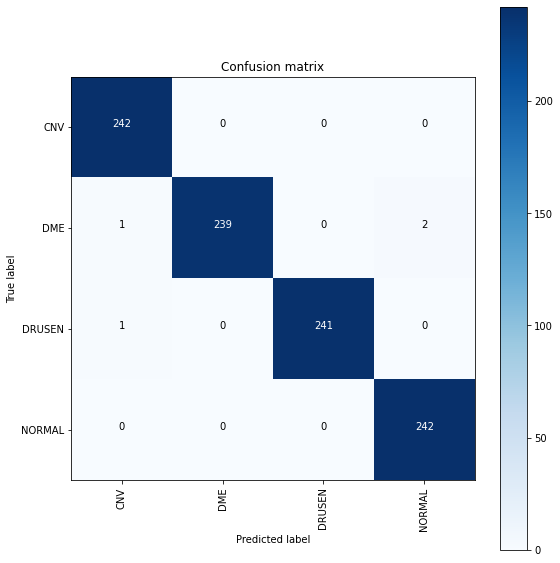

In [ ]:
# confusion matrix
cm = confusion_matrix(Y_true, Y_pred)
 
print('--------------------')
print('| Confusion Matrix |')
print('--------------------')
print('\n {}'.format(cm))
        
# plot confusin matrix
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix1(cm, classes=['CNV','DME','DRUSEN','NORMAL'], normalize=False, 
                      title='Confusion matrix', cmap = plt.cm.Blues)
plt.show()

In [ ]:
model.save("/content/drive/My Drive/Colab Notebooks/xmodel2.h5")

In [ ]:
score=model.evaluate(val_batch)
print(score[1])

108/108 [==============================] - 6s 53ms/step - loss: 0.2133 - accuracy: 0.9305
0.9305092096328735


In [ ]:
y_pred = model.predict(x_val)
Y_pred = np.argmax(y_pred,axis = 1)
Y_true = np.argmax(y_val,axis = 1)

In [ ]:
y_val[0]

array([0., 0., 1., 0.], dtype=float32)

In [ ]:
Y_true[0]

2

In [ ]:
y_pred[0]

array([2.2036867e-05, 9.9171174e-01, 9.9634453e-14, 8.2662785e-03],
      dtype=float32)

In [ ]:
Y_pred[0]

1

In [ ]:
print(Y_pred[:100])


[1 0 3 1 1 0 1 1 1 1 3 1 1 1 3 1 1 1 1 1 3 1 1 3 1 1 3 1 1 1 1 1 3 1 1 1 1
 1 1 3 1 1 3 3 1 1 3 1 1 1 1 1 3 3 3 1 3 1 1 3 3 3 1 1 1 1 1 3 3 1 1 1 1 1
 3 1 1 3 3 1 1 1 3 3 1 1 1 1 1 1 3 1 3 3 1 1 3 1 1 1]


In [ ]:
print(Y_true[:100])

[2 2 1 3 3 1 3 1 3 2 2 1 1 1 2 1 3 0 3 1 0 1 0 0 3 3 0 3 0 1 2 0 2 0 0 3 0
 1 1 0 1 0 1 3 0 3 1 0 0 2 1 0 1 2 3 2 3 2 0 0 2 0 1 1 1 2 1 3 3 0 2 2 2 1
 0 1 0 2 0 0 0 0 0 3 3 0 2 1 1 0 0 1 0 0 1 1 0 0 2 3]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_true,Y_pred,target_names=['CNV','DME','DRUSEN','NORMAL']))

              precision    recall  f1-score   support

         CNV       0.24      0.24      0.24      1733
         DME       0.25      0.24      0.25      1727
      DRUSEN       0.25      0.24      0.24      1720
      NORMAL       0.25      0.27      0.26      1713

    accuracy                           0.25      6893
   macro avg       0.25      0.25      0.25      6893
weighted avg       0.25      0.25      0.25      6893



In [ ]:
y_pred = np.round(model.predict(x_test),0)
print('rounded',y_pred)

rounded [[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]
